In [1]:
import sys
import platform

print(sys.version)
print(platform.processor())

3.8.2 (tags/v3.8.2:7b3ab59, Feb 25 2020, 23:03:10) [MSC v.1916 64 bit (AMD64)]
Intel64 Family 6 Model 142 Stepping 12, GenuineIntel


In [2]:
from collections import defaultdict
from time import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


pd.options.display.float_format = '{:.2f}'.format


def draw_x_y(frames, labels, x, y):
    for i in range(len(frames)):
        plt.scatter(frames[i][x], frames[i][y], s=1, marker='.', label=labels[i])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid('both')
    plt.legend()
    plt.show()

    
def draw_i_y(frames, labels, y):
    for i in range(len(frames)):
        plt.scatter(frames[i].index, frames[i][y], s=1, marker='.', label=labels[i])
    plt.xlabel('iteration')
    plt.ylabel(y)
    plt.grid('both')
    plt.legend()
    plt.show()

# Local Searchers

In [3]:
from src.algorithms.structures.matrix import adjacency_matrix
from src.algorithms.utils.generator import generator
from src.utils import draw_tour

from src.lkh_search import LKHSearch
from src.tabu_search import TabuSearch

In [11]:
def one_test(search, size, iterations, swap=2, draw=False, **kwargs):
    tsp = generator(size)
    matrix = adjacency_matrix(tsp)
    searcher = search(matrix=matrix, collect=True, **kwargs)
    searcher.optimize(iterations=iterations, swap=swap)
    frame = searcher.collector.as_frame()
    frame['time'] = frame['time'] - frame['time'][1]
    frame = frame[1:]
    draw_x_y([frame], [f'{len(tsp)}'], 'time', 'length')
    if draw:
        draw_tour(searcher.tour, tsp)
        
def executor(search, tests, parameter, values, iterations, swap=2):
    frame = defaultdict(list)
    for test in tests:
        tsp = generator(test)
        matrix = adjacency_matrix(tsp)
        for value in values:
            kwargs = {parameter: value}
            t_start = time()
            searcher = search(matrix=matrix, **kwargs)
            searcher.optimize(iterations=iterations, swap=swap)
            frame[f'{value}-time'].append(time() - t_start)
            frame[f'{value}-length'].append(searcher.length)
    print(pd.DataFrame(frame))

## LKH Search

Based on LKH-1 search heuristic

### General View

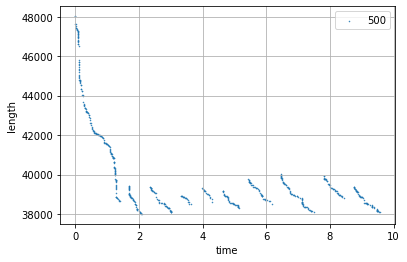

In [8]:
one_test(LKHSearch, 500, 10, init='fast_helsgaun')

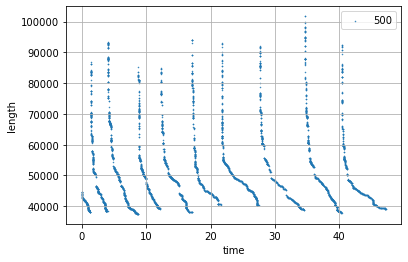

In [6]:
one_test(LKHSearch, 500, 10, init='helsgaun')

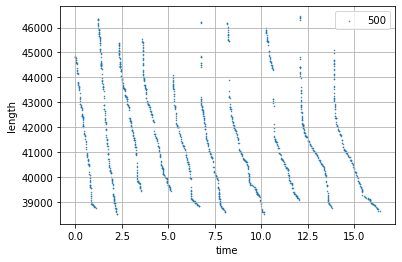

In [7]:
one_test(LKHSearch, 500, 10, init='greedy')

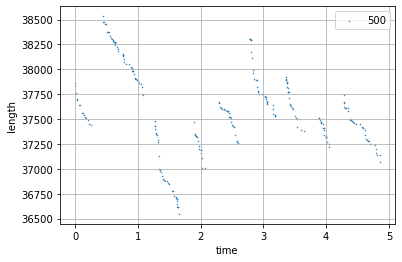

In [39]:
one_test(LKHSearch, 500, 10, init='two_opt', two_opt=True)

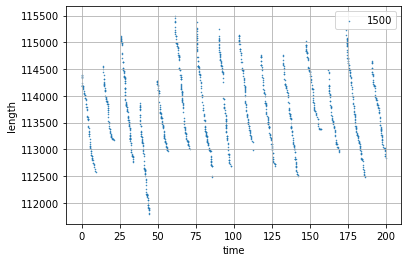

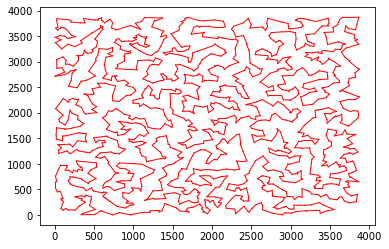

In [5]:
one_test(LKHSearch, 1500, 15, init='two_opt', two_opt=True, draw=True)

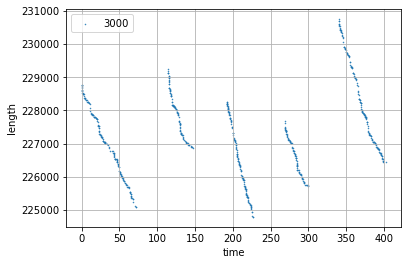

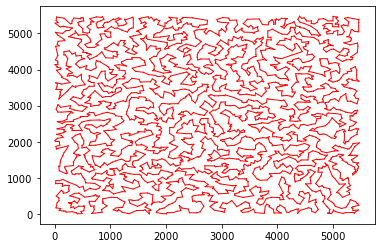

In [5]:
one_test(LKHSearch, 3000, 5, init='two_opt', two_opt=True, draw=True)

### Init Type

In [18]:
executor(LKHSearch, [50, 100, 200], 'init', ['fast_helsgaun', 'helsgaun', 'two_opt', 'greedy'], 30)

   fast_helsgaun-time  fast_helsgaun-length  helsgaun-time  helsgaun-length  \
0                0.08               3741.85           0.66          3743.72   
1                0.49               8045.21           3.88          7962.64   
2                3.65              15469.97          25.20         15714.24   

   two_opt-time  two_opt-length  greedy-time  greedy-length  
0          0.05         3815.79         0.18        3743.72  
1          0.45         7965.77         2.13        8027.68  
2          2.02        15630.03         9.04       15577.39  


In [24]:
executor(LKHSearch, [400, 800], 'init', ['fast_helsgaun', 'two_opt'], 15)

   fast_helsgaun-time  fast_helsgaun-length  two_opt-time  two_opt-length
0                9.11              31412.81          4.67        31206.57
1               65.94              60714.26         38.53        60726.56


### DLB

In [23]:
executor(LKHSearch, [50, 100, 200, 400, 800], 'dlb', [True, False], 15)

   True-time  True-length  False-time  False-length
0       0.07      4193.63        0.13       4145.89
1       0.31      7856.38        0.58       7949.62
2       1.63     15605.53        2.44      15702.95
3      10.37     30563.96       16.07      30114.32
4      62.58     61046.67      101.33      60443.32


### Two Opt

In [22]:
executor(LKHSearch, [50, 100, 200, 400, 800], 'two_opt', [True, False], 1)

   True-time  True-length  False-time  False-length
0       0.01      4194.34        0.01       4177.77
1       0.03      7974.49        0.06       8056.90
2       0.14     15776.26        0.20      15519.29
3       0.65     31734.40        1.51      31537.01
4       4.06     60706.14        7.97      61571.44


## Tabu Search

### General View

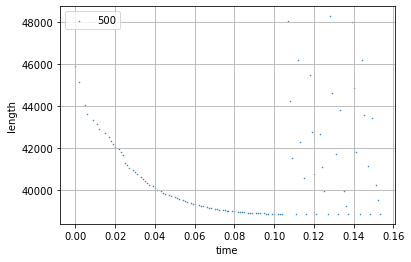

In [38]:
one_test(TabuSearch, 500, 10, swap=2, opt='two_opt')

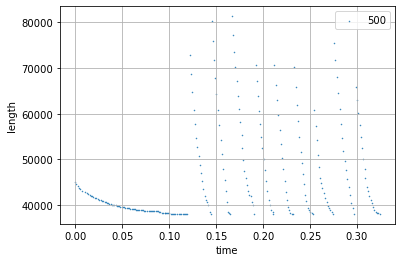

In [29]:
one_test(TabuSearch, 500, 10, swap=8, opt='two_opt')

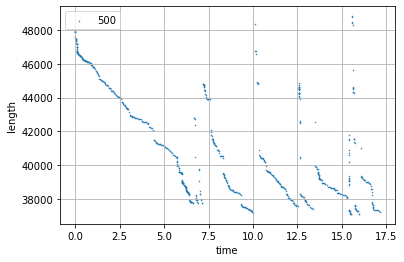

In [34]:
one_test(TabuSearch, 500, 10, swap=2, opt='lk_opt')

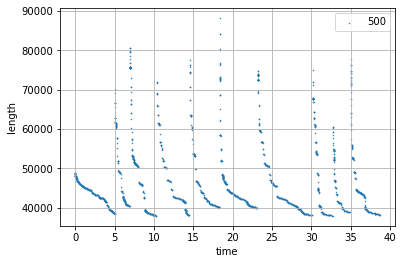

In [35]:
one_test(TabuSearch, 500, 10, swap=8, opt='lk_opt')

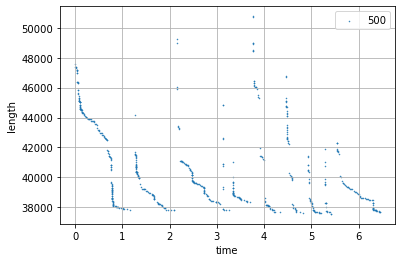

In [36]:
one_test(TabuSearch, 500, 10, swap=2, opt='lkh_opt')

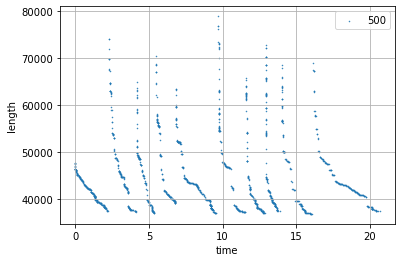

In [37]:
one_test(TabuSearch, 500, 10, swap=8, opt='lkh_opt')

### Swap

In [43]:
frame = defaultdict(list)
for test in [50, 100, 200, 400, 800]:
    tsp = generator(test)
    matrix = adjacency_matrix(tsp)
    for value in [2, 4, 6, 8]:
        t_start = time()
        searcher = TabuSearch(opt='lkh_opt', matrix=matrix)
        searcher.optimize(iterations=15, swap=value)
        frame[f'{value}-time'].append(time() - t_start)
        frame[f'{value}-length'].append(searcher.length)
print(pd.DataFrame(frame))

   2-time  2-length  4-time  4-length  6-time  6-length  8-time  8-length
0    0.20   3886.78    0.21   3929.12    0.25   3886.78    0.31   3966.16
1    0.59   7919.85    0.78   7937.99    1.04   7924.59    1.26   7921.58
2    1.34  14888.35    2.70  14890.88    3.75  14826.82    3.96  14827.22
3    4.35  30594.40   10.00  30430.29   18.38  30117.95   17.90  30321.79
4   30.90  60173.34   43.67  60163.23   47.76  60101.57   65.45  60021.16


# Local optimization algorithms

In [10]:
from src.algorithms.two_opt import TwoOpt
from src.algorithms.three_opt import ThreeOpt
from src.algorithms.lk_opt import LKOpt
from src.algorithms.lkh_opt import LKHOpt

from src.algorithms.structures.matrix import adjacency_matrix
from src.algorithms.utils.generator import generator
from src.algorithms.utils.initial_tour import greedy

In [12]:
def generate_data(size, tries):
    data = []
    for _ in range(tries):
        tsp = generator(size)
        matrix = adjacency_matrix(tsp)
        length, tour = greedy(matrix)
        data.append((length, tour, matrix))
    return data


def one_test(size, three=False):
    data = generate_data(size, 1)
    two_opt = generate_results(TwoOpt, data)
    lk_opt = generate_results(LKOpt, data)
    lkh_opt = generate_results(LKHOpt, data)
    if three:
        three_opt = generate_results(ThreeOpt, data)

    opts = [two_opt, lk_opt, lkh_opt, three_opt] if three else [two_opt, lk_opt, lkh_opt]
    names = [f"two_opt {two_opt['length'].min():0.1f}", 
             f"lk_opt {lk_opt['length'].min():0.1f}", 
             f"lkh_opt {lkh_opt['length'].min():0.1f}"]
    if three:
        names.append(f"three_opt {three_opt['length'].min():0.1f}")

    draw_x_y(opts, names, 'time', 'length')

    
def generate_results(optimizer, data, **kwargs):
    all_frames = None
    for length, tour, matrix in data:
        opt = optimizer(length, tour.copy(), matrix.copy(), collect=True, **kwargs)
        opt.optimize()

        frame = opt.collector.as_frame()
        frame['time'] = frame['time'] - frame['time'][1]
        frame = frame[1:]
        if all_frames is None:
            all_frames = frame
        else:
            all_frames = all_frames.append(frame)
    return all_frames

## General view for all optimizations

Little can be seen on homogeneous data, but something very general...

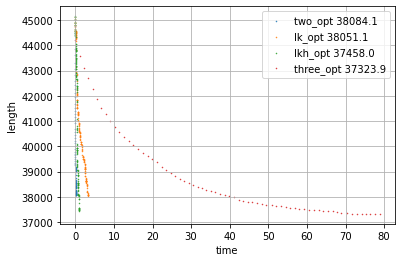

In [13]:
one_test(500, True)

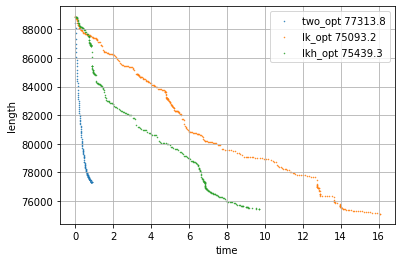

In [14]:
one_test(1000)

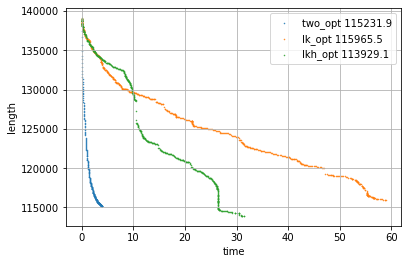

In [15]:
one_test(1500)

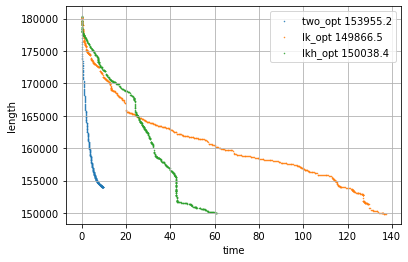

In [16]:
one_test(2000)

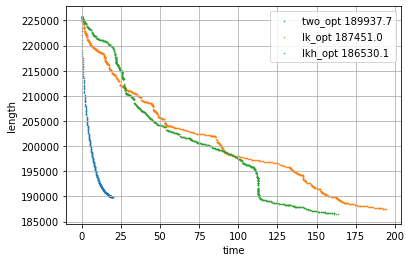

In [17]:
one_test(2500)

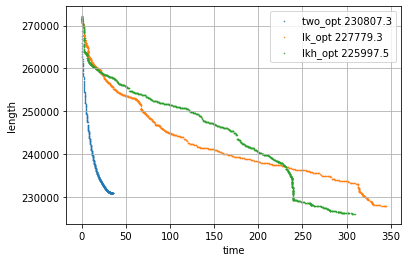

In [19]:
one_test(3000)

## On the average

In [ ]:
def average(func, tests, n, three=False):
    _frame = defaultdict(list)
    _frame['tests'] = tests

    for size in tests:
        frame = defaultdict(list)
        samples = generate_data(size, n)
        for length, tour, matrix in samples:
            run(TwoOpt, frame, 'two_opt', length, tour, matrix)
            run(LKOpt, frame, 'lk_opt', length, tour, matrix)
            run(LKHOpt, frame, 'lkh_opt', length, tour, matrix)
            if three:
                run(ThreeOpt, frame, 'three_opt', length, tour, matrix)
        frame = pd.DataFrame(frame)
        _frame['two_opt'].append(frame['two_opt'].mean())
        _frame['lk_opt'].append(frame['lk_opt'].mean())
        _frame['lkh_opt'].append(frame['lkh_opt'].mean())
        if three:
            _frame['three_opt'].append(frame['three_opt'].mean())

    print(pd.DataFrame(_frame))

### Length

In [28]:
def run(optimizer, frame, name, length, tour, matrix, **kwargs):
    opt = optimizer(length, tour.copy(), matrix.copy(), **kwargs)
    opt.optimize()
    frame[name].append(100 - opt.length / (length / 100))

print('Better then initial (%):') 
average(run, [25, 50, 100, 200], 15, True)
average(run, [400, 800], 10)

Better then initial (%):
   tests  two_opt  lk_opt  lkh_opt  three_opt
0     25    16.87   16.76    17.10      17.95
1     50    13.72   13.77    13.24      15.40
2    100    17.03   18.60    18.62      19.58
3    200    15.47   17.14    17.18      17.31
   tests  two_opt  lk_opt  lkh_opt
0    400    16.62   17.87    17.29
1    800    14.69   15.80    16.15


### Time

In [27]:
def run(optimizer, frame, name, length, tour, matrix, **kwargs):
    t_start = time()
    opt = optimizer(length, tour.copy(), matrix.copy(), **kwargs)
    opt.optimize()
    frame[name].append(time() - t_start)

print('Time (s):') 
average(run, [25, 50, 100, 200], 15, True)
average(run, [400, 800], 10)

Time (s):
   tests  two_opt  lk_opt  lkh_opt  three_opt
0     25     0.00    0.01     0.01       0.00
1     50     0.00    0.03     0.02       0.01
2    100     0.00    0.12     0.07       0.16
3    200     0.01    0.67     0.30       2.20
   tests  two_opt  lk_opt  lkh_opt
0    400     0.07    2.54     1.50
1    800     0.61   12.93     7.73


### Iterations

In [26]:
def run(optimizer, frame, name, length, tour, matrix, **kwargs):
    opt = optimizer(length, tour.copy(), matrix.copy(), collect=True, **kwargs)
    opt.optimize()
    frame[name].append(len(opt.collector.as_frame()))

print('Iterations:') 
average(run, [25, 50, 100, 200], 15, True)
average(run, [400, 800], 10)

Iterations:
   tests  two_opt  lk_opt  lkh_opt  three_opt
0     25     5.00    7.33     7.00       5.07
1     50    10.80   18.80    18.27       8.67
2    100    20.33   37.73    36.93      16.27
3    200    37.53   77.93    68.47      29.20
   tests  two_opt  lk_opt  lkh_opt
0    400    68.70  158.60   138.90
1    800   134.80  322.50   280.50


## Lin-Kernighan

In [122]:
def runner(optimizer, frame, value, length, tour, matrix, **kwargs):
    t_start = time()
    opt = optimizer(length, tour.copy(), matrix.copy(), **kwargs)
    opt.optimize()
    frame[f'{value}time'].append(time() - t_start)
    frame[f'{value}length'].append(100 - opt.length / (length / 100))
    
def executor(opt, tests, values, parameter, n):
    length_frame = defaultdict(list)
    time_frame = defaultdict(list)
    
    for size in tests:
        frame = defaultdict(list)
        samples = generate_data(size, n)
        for length, tour, matrix in samples:
            for value in values:
                kwargs = {parameter: value}
                runner(opt, frame, value, length, tour, matrix, **kwargs)
        frame = pd.DataFrame(frame)
        for value in values:
            length_frame[f'{parameter}={value}'].append(frame[f'{value}length'].mean())
            time_frame[f'{parameter}={value}'].append(frame[f'{value}time'].mean())
            
    print('-----')
    length_frame = pd.DataFrame(length_frame)
    time_frame = pd.DataFrame(time_frame)
    print('Better then initial (%):') 
    print(length_frame)
    print('Time (s)')
    print(time_frame)  

### K-opt

In [123]:
executor(LKOpt, [25, 50, 100, 200, 400], [3, 5, 7, 9, 11], 'k', 10)

-----
Better then initial (%):
    k=3   k=5   k=7   k=9  k=11
0 15.51 15.34 15.34 15.34 15.34
1 15.91 16.63 16.96 17.20 17.15
2 13.74 15.43 15.38 15.45 15.46
3 16.88 17.72 17.98 18.78 18.33
4 16.79 17.26 17.35 18.13 17.86
Time (s)
   k=3  k=5  k=7  k=9  k=11
0 0.00 0.01 0.01 0.01  0.01
1 0.02 0.03 0.03 0.04  0.04
2 0.05 0.08 0.12 0.15  0.18
3 0.33 0.65 1.09 2.01  4.51
4 1.22 2.23 3.82 5.97  7.46


### Neighbours

In [124]:
executor(LKOpt, [25, 50, 100, 200, 400], [5, 10, 15, 20], 'neighbours', 10)

-----
Better then initial (%):
   neighbours=5  neighbours=10  neighbours=15  neighbours=20
0         14.88          15.70          15.63          15.63
1         16.74          17.75          17.23          17.33
2         18.07          19.47          19.65          19.51
3         17.02          18.64          18.70          18.75
4         17.70          18.88          19.14          19.06
Time (s)
   neighbours=5  neighbours=10  neighbours=15  neighbours=20
0          0.01           0.01           0.02           0.02
1          0.03           0.07           0.09           0.09
2          0.11           0.23           0.32           0.33
3          0.59           1.23           1.44           2.05
4          2.44           7.20           5.65           7.03


### With / Without: DLB

In [125]:
executor(LKOpt, [25, 50, 100, 200, 400], [True, False], 'dlb', 10)

-----
Better then initial (%):
   dlb=True  dlb=False
0     18.85      18.88
1     17.47      17.81
2     16.52      17.58
3     16.29      17.95
4     16.76      16.43
Time (s)
   dlb=True  dlb=False
0      0.01       0.01
1      0.02       0.03
2      0.08       0.15
3      0.28       0.51
4      1.39       2.41


### With / With Fast / Without: Double Bridge

In [126]:
executor(LKOpt, [25, 50, 100, 200, 400], [(2, False), (2, True), (0, False)], 'bridge', 10)

-----
Better then initial (%):
   bridge=(2, False)  bridge=(2, True)  bridge=(0, False)
0              12.26             12.26              12.01
1              16.73             16.73              15.70
2              17.00             16.91              16.14
3              16.03             16.05              15.93
4              17.57             17.58              17.35
Time (s)
   bridge=(2, False)  bridge=(2, True)  bridge=(0, False)
0               0.01              0.01               0.01
1               0.03              0.03               0.03
2               0.11              0.10               0.09
3               0.60              0.65               0.60
4               2.84              2.72               2.66


## Lin-Kernighan-Helsgaun

### K-opt

In [127]:
executor(LKHOpt, [25, 50, 100, 200, 400], [3, 5, 7, 9, 11], 'k', 10)

-----
Better then initial (%):
    k=3   k=5   k=7   k=9  k=11
0 14.40 14.55 14.82 15.07 15.07
1 15.26 15.32 16.19 16.30 15.80
2 18.47 18.70 19.00 19.30 19.24
3 16.41 16.75 17.25 16.95 17.43
4 18.37 19.11 19.18 19.36 19.27
Time (s)
   k=3  k=5  k=7  k=9  k=11
0 0.01 0.01 0.01 0.02  0.03
1 0.03 0.03 0.04 0.07  0.13
2 0.11 0.12 0.17 0.22  0.23
3 0.41 0.52 0.60 0.90  1.20
4 2.02 2.39 3.12 4.34  6.68


### With / Without Subgradient

In [128]:
executor(LKHOpt, [25, 50, 100, 200, 400], [True, False], 'subgradient', 10)

-----
Better then initial (%):
   subgradient=True  subgradient=False
0             12.50              11.55
1             15.22              15.31
2             17.03              17.03
3             17.21              17.07
4             19.05              18.75
Time (s)
   subgradient=True  subgradient=False
0              0.04               0.01
1              0.07               0.04
2              0.28               0.18
3              1.01               0.59
4              4.89               2.81


### Mul for excess

In [129]:
executor(LKHOpt, [25, 50, 100, 200, 400], [1, 2, 3], 'mul', 10)

-----
Better then initial (%):
   mul=1  mul=2  mul=3
0  13.54  13.89  13.89
1  13.54  14.16  14.11
2  17.38  17.40  17.24
3  17.30  17.28  17.63
4  17.81  18.43  18.40
Time (s)
   mul=1  mul=2  mul=3
0   0.01   0.01   0.01
1   0.02   0.04   0.06
2   0.07   0.16   0.29
3   0.36   0.66   1.47
4   1.90   3.12   7.02


### With / Without Non Seq

In [130]:
executor(LKHOpt, [25, 50, 100, 200, 400], [True, False], 'non_seq', 10)

-----
Better then initial (%):
   non_seq=True  non_seq=False
0         13.18          13.18
1         14.90          14.46
2         18.72          18.20
3         18.49          17.91
4         19.23          18.92
Time (s)
   non_seq=True  non_seq=False
0          0.12           0.01
1          0.87           0.04
2          3.98           0.16
3         16.01           0.60
4         54.66           3.24
